The code below will accompany a Medium post.

In [50]:
# imports
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import plotly
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='zangell', api_key='bs2CJxqOA2hlrJXKyeM9')

# load data
df_train = pd.read_csv('train_features.csv', index_col=0).join(pd.read_csv('train_labels.csv', index_col=0))

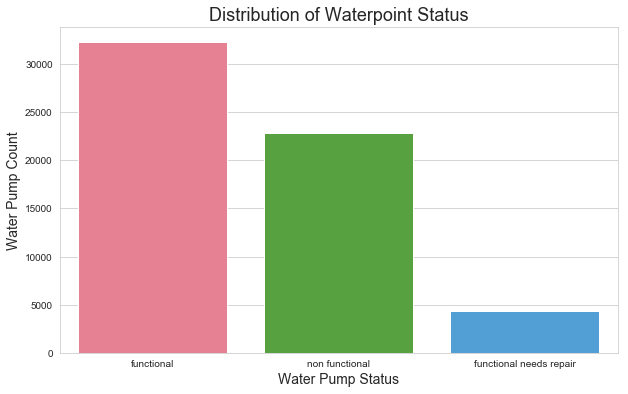

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(df_train['status_group'],
              palette=sns.color_palette("husl", 3),
              ax=ax)
ax.set_title('Distribution of Waterpoint Status', fontsize=18)
ax.set_xlabel('Water Pump Status', fontsize=14)
ax.set_ylabel('Water Pump Count', fontsize=14);

In [55]:
df_train['status_group'].value_counts()[0]

32259

In [57]:
x = ['Functional', 'Non-Functional', 'Functional, In Need of Repair']
y = [df_train['status_group'].value_counts()[0], 
     df_train['status_group'].value_counts()[1], 
    df_train['status_group'].value_counts()[2]]

data = [go.Bar(
            x=x,
            y=y,
            text=y,
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6
        )]

layout = go.Layout(
    title='Functional Status Count',
    xaxis=dict(
        title='Functional Status',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Observations',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='bar-test')

/Users/zach/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Fitting a Simple Model Using Funder as a Feature

In [24]:
# simple logistic regression using funder variable
def map_funder(funder):
    """
    Takes in the name of an entity and categorizes it
    """
    unknown = ['0', 'unknown']  
    if funder in unknown:
        return 'unknown' 
    government = ['government ', 'government', 'dwe', 'hesawa', 'rwe', 'central government', 'lga',
                 'district council', 'gover', 'gove', 'gov', 'district water department',
                 'sengerema water department', 'distri', 'centr', 'distric water department',
                 'tasaf']  
    if funder in government:
        return 'government'  
    community = ['community', 'commu', 'villagers', 'twesa']   
    if funder in community:
        return 'community'    
    religious = ['church of disciples', 'kkkt', 'world vision', 'rc church', 'rc', 'tcrs',
                'dmdd']    
    if funder in religious:
        return 'religious'    
    international = ['norad', 'fini water', 'danida', 'danid', 'ces', 'kuwait',
                    'finw']    
    if funder in international:
        return 'international'   
    private = ['private', 'privat', 'kiliwater', 'wedeco']    
    if funder in private:
        return 'private'    
    aid = ['roman', 'amref', 'world bank', 'unicef', 'oxfam']    
    if funder in aid:
        return 'aid'
    return 'other'

In [48]:
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.pipeline import make_pipeline

# create new variable for funding group
X = ce.OneHotEncoder(use_cat_names=True).fit_transform(df_train['funder'].str.lower().apply(map_funder).values)
# create binary target variable
y = df_train['status_group'] == 'functional'

# fit logistic regresssion and report coefficients
lr = LogisticRegression(solver='lbfgs').fit(X, y)
# neat print formatting
print ('-' * 35)
print('{:<20s}{:>15s}'.format('Feature','Coefficient'))
print ('-' * 35)
for feat, coef in (zip(X.columns, lr.coef_[0])):
    print('{:<20s}{:>15f}'.format(feat[2:],round(coef,2)))

-----------------------------------
Feature                 Coefficient
-----------------------------------
aid                       -0.170000
other                     -0.000000
private                    0.640000
international             -0.400000
religious                  0.190000
government                -0.460000
unknown                    0.060000
community                  0.360000
-1                         0.000000


--------------------------------------------------------------------------------
Feature                                               Coefficient
--------------------------------------------------------------------------------
aid                                                     -0.170000
other                                                   -0.000000
private                                                  0.640000
international                                           -0.400000
religious                                                0.190000
government                                              -0.460000
unknown                                                  0.060000
community                                                0.360000
-1                                                       0.000000


## Visualizing Waterpoint Access Issues

In [73]:
mapbox_access_token = 'pk.eyJ1IjoiemFuZ2VsbDQ0IiwiYSI6ImNqcndjeWg0MjBiZmI0YW10YWZmbnFjbncifQ.Fy89S3B5DvrYWkbWJ8FyjA'

df_plot = df_train[df_train['longitude']>25].sample(5000)

data = [
    # functional pumps
    go.Scattermapbox(
        lat=df_plot['latitude'][df_train['status_group'] == 'functional'],
        lon=df_plot['longitude'][df_train['status_group'] == 'functional'],
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(0, 255, 0)',
            opacity=0.7
        ),
        text=['Functional'],
        hoverinfo='text',
        name='Functional'
    ),
    go.Scattermapbox(
        lat=df_plot['latitude'][df_train['status_group'] == 'non functional'],
        lon=df_plot['longitude'][df_train['status_group'] == 'non functional'],
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=['Non-Functional'],
        hoverinfo='text',
        name='Non-Functional'
    ),
    go.Scattermapbox(
        lat=df_plot['latitude'][df_train['status_group'] == 'functional needs repair'],
        lon=df_plot['longitude'][df_train['status_group'] == 'functional needs repair'],
        mode='markers',
        marker=dict(
            size=2,
            color='rgb(0, 0, 255)',
            opacity=0.7
        ),
        text=['Functional, Needs Repair'],
        hoverinfo='text',
        name='Functional, Needs Repair'
    )
]

layout = go.Layout(
    autosize=False,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=-7,
            lon=39
        ),
        pitch=0,
        zoom=4
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Tanzania Mapbox')

/Users/zach/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [68]:
df_train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64